In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import kornia
import torchvision
from torch import nn
from torch.nn import functional as F
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Image Data Loader

In [2]:
class image_loader(torch.utils.data.Dataset):

    def __init__(self, batch_size, directory):
        super().__init__()
        
        self.image_dir = directory
        self.batch_size = batch_size
        self.all_file_paths = [directory + file_name for file_name in os.listdir(directory)]
    
    def __len__(self):
        
        return len(self.all_file_paths)//self.batch_size

    def __getitem__(self, batch_number, training = False):
        
        image_numbers = range(batch_number * self.batch_size, (batch_number+1) * self.batch_size)

        # Batch Size x Channels x Height x Width
        batch_l_channel = torch.empty((0, 1, h_image_size, h_image_size))
        batch_ab_channels = torch.empty((0, 2, h_image_size, h_image_size))
        for image_number in image_numbers:

            image_l_channel, image_ab_channels = self.load_processed_image_channels(image_number, training)
            
            batch_l_channel = torch.cat((batch_l_channel, image_l_channel),0)
            batch_ab_channels = torch.cat((batch_ab_channels, image_ab_channels))

        return batch_l_channel, batch_ab_channels

    def load_processed_image_channels(self, image_number, training = False):

        image = torchvision.io.read_image(self.all_file_paths[image_number])
        
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        
        if training:
            image = torchvision.transforms.RandomHorizontalFlip()(image)
            image = torchvision.transforms.RandomVerticalFlip()(image)
        image = image = torch.unsqueeze(image,0)
        # Get RGB values between 0 and 1
        image = image/256
        image = kornia.color.rgb_to_lab(image)

        # L values 1 - 100 --> -1 - 1
        l_channel = torch.subtract(image[:,0,:,:],50)/50
        # AB values -128 - 127 --> -1 - 1
        ab_channels = image[:,1:,:,:]/128
        
        return torch.unsqueeze(l_channel,0), ab_channels

    def load_unprocessed_image(self, image_number):
        
        image = torchvision.io.read_image(self.all_file_paths[image_number])
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        
        image = image.movedim(0,-1)
        
        return image

# Downsampling Block for U-Net Encoder

In [3]:
class Downsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        # Output height and width = 1/2 x input height and width
        self.conv = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 5, stride = 2 ,padding=2)

        # Output height and width = 1/2 x input height and width
        self.residual = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 1, stride = 2)
        
        self.norm = nn.BatchNorm2d(out_filters)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):

        block = self.conv(x)
        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        residual = self.residual(x)
        block = torch.add(block, residual)
        
        return block

# Upsampling Block for U-Net Decoder

In [4]:
class Upsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        # Output height and width = 2 x input height and width
        self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 4, stride = 2,
                                      padding=1)

        # Output height and width = 2 x input height and width
        self.residual = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 1, stride = 2,
                                     output_padding=1)
        
        self.norm = nn.BatchNorm2d(out_filters)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x, skip):

        block = self.conv(x)

        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        residual = self.residual(x)
        block = torch.add(block, residual)
        # Concatenate skip connection on channel axis
        block = torch.cat((block, skip),1)
        
        return block

# U-Net Model Definition

In [5]:
class Generator(nn.Module):

    def __init__(self, image_size, max_filters):
        super().__init__()

        # Number of layers changes based on the shape of the input images
        # to reduce image size to 1 x 1 in the bottom layer
        self.n_layers = int(np.floor(np.log2(image_size)))
        self.max_filters = max_filters
        
        self.input = nn.Conv2d(in_channels = 1,out_channels = 16, kernel_size = 5,
                               padding= 2)
        
        self.finalconv = nn.ConvTranspose2d(in_channels = 32, out_channels=2, kernel_size=1, stride=1)

        self.apply(self.__init_weights)

        # ==== Create Downsampling Stack ====
        
        self.downstack = []
        # Output filters is double the number of input filters unless it would exceed max filters
        # First layer always starts with 16 filters
        for layer in range(self.n_layers):
            if 2 ** (4+layer) < self.max_filters:
                self.downstack.append(Downsampling(in_filters=2 ** (4+layer),
                                                   out_filters=2 ** (5+layer)))
            else:
                self.downstack.append(Downsampling(in_filters=self.max_filters,
                                                   out_filters=self.max_filters))
                
        self.downstack = nn.ModuleList(self.downstack)   

        # ==== Initial Layer for Upsampling Stack ====

        # Bottom layer of upsampling stack should have the same number of filters as the last
        # downsampling stack outputs
        if 2 ** (4+self.n_layers) > self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters,
                                            out_filters = self.max_filters)]         
        elif 2 ** (4+self.n_layers) == self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters,
                                            out_filters = 2 ** (3+self.n_layers))]
        else: 
            self.upstack_init = [Upsampling(in_filters = 2 ** (4+self.n_layers),
                                            out_filters = 2 ** (3+self.n_layers))]

        # ==== Create Remaining Upsampling Stack ====
        
        self.upstack = []
        for layer in range(self.n_layers-1):
            if 2**(self.n_layers - layer + 3) > self.max_filters:
                self.upstack.append(Upsampling(in_filters = 2 * self.max_filters,
                                                out_filters = self.max_filters))
            else:
                self.upstack.append(Upsampling(in_filters = 2**(self.n_layers - layer + 4),
                                                out_filters = 2**(self.n_layers - layer + 2)))
                
        self.upstack = nn.ModuleList(self.upstack_init + self.upstack)

        print(self.downstack)
        print(self.upstack)
        
    def __init_weights(self, module):

        if isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, x):
        
        skips = []
        conv = self.input(x)
        skips.append(conv)
        for x in self.downstack:
            skipconv = x(conv)
            skips.append(skipconv)
            conv = skips[-1]
            
        for idx, layer in enumerate(self.upstack):
            conv = layer(conv, skips[-(idx+2)])
        
        out = self.finalconv(conv)
        out = F.tanh(out)

        return out

    def colorize(self, x):

        predictions = self.forward(x).detach()
        x_adj = torch.add(x*50,50).to(torch.long)
        predictions = (predictions * 128).to(torch.long)
        image = torch.cat((x_adj, predictions),1)    
        image = kornia.color.lab_to_rgb(torch.squeeze(image,0))
        image = image.movedim(0,-1)
        
        return image

# Hyperparameters

In [6]:
h_epochs = 5
h_saves = 5
h_image_size = 32
h_max_allowable_filters = 512
h_batch_size = 500
h_train_dir = 'Train/'
h_test_dir = 'Test/'

# Initialize Model - Optimizer - Data Loaders

In [7]:
generator = Generator(h_image_size, h_max_allowable_filters).to(device)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
train_data_loader = image_loader(h_batch_size, h_train_dir)
test_data_loader = image_loader(1, h_test_dir)

saved_epochs = []
losses = []

ModuleList(
  (0): Downsampling(
    (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (residual): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (1): Downsampling(
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (residual): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (2): Downsampling(
    (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (residual): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropo

# Training Model

In [8]:
with torch.autograd.profiler.profile() as prof:
    generator.train();
    for epoch in tqdm(range(h_epochs)):
        for batch_number in range(len(train_data_loader)):
    
            x, y = train_data_loader.__getitem__(batch_number, training=True)
            x, y = x.to(device), y.to(device)
            
            model_out = generator.forward(x)
            loss = F.mse_loss(model_out,y)
            
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            losses.append(loss.to('cpu'))
           
        if not ((epoch+1) % (h_epochs//h_saves)):
            
            generator.eval()
    
            x, y = train_data_loader.load_processed_image_channels(42)
            x, y = x.to(device), y.to(device)
            predictions = generator.colorize(x)
            saved_epochs.append(predictions.to('cpu').numpy())
            
            generator.train()
        
        
    generator.eval();      
print(prof.key_averages().table(sort_by="self_cpu_time_total"))
#torch.save(gen, 'gen.pth')

STAGE:2023-11-26 13:34:08 175913:175913 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
100%|█████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.03s/it]
STAGE:2023-11-26 13:35:19 175913:175913 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-26 13:35:22 175913:175913 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
[W collection.cpp:1035] Warning: ROCTracer produced duplicate flow start: 3 (function operator())


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    image::decode_image        19.36%        9.156s        19.79%        9.364s     187.260us         50005  
                                    hipMemcpyWithStream        15.51%        7.337s        15.51%        7.337s      22.927ms           320  
                               hipExtModuleLaunchKernel        11.94%        5.648s        11.94%        5.648s       6.197us        911405  
                             aten::convolution_backward        10.19%        4.821s        22.71%       10.745s       4.884ms          2200  
      

# Loss

Text(0, 0.5, 'MSE Loss')

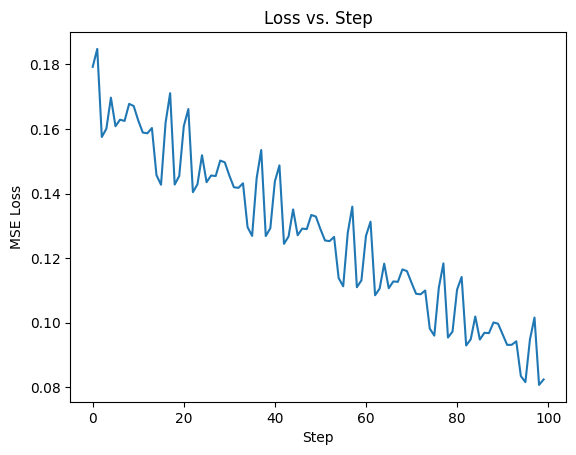

In [9]:
losses = [loss.to('cpu').detach().numpy() for loss in losses]
fig, ax = plt.subplots()
ax.plot(range(len(losses)),losses)
ax.set_title('Loss vs. Step')
ax.set_xlabel('Step')
ax.set_ylabel('MSE Loss')

# Epoch Examples

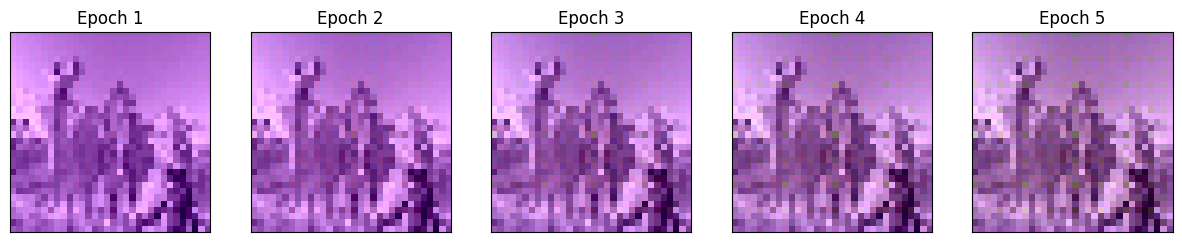

In [10]:
rows = (np.ceil(len(saved_epochs)/5)).astype(int)
skips = h_epochs // h_saves

if rows == 1:
    fig, ax = plt.subplots(1,5,figsize=(15,3))
    for index, axis in enumerate(ax):
        try:
            axis.imshow(saved_epochs[index])
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_title(f'Epoch {1+(index * h_epochs // h_saves)}')
        except:
            pass
else:
    fig, ax = plt.subplots(rows,5,figsize=(15,3*rows))
    for row_no, row in enumerate(ax):
        for index, axis in enumerate(row):
            try:
                axis.imshow(saved_epochs[index + 5* row_no])
                axis.set_xticks([])
                axis.set_yticks([])
                axis.set_title(f'Epoch {1 + (5 * row_no * skips) + (index * skips)}')
            except:
                pass

# Display Example Images

In [11]:
def show_example_images(loader, number, offset):

    fig, ax = plt.subplots(number, 3, figsize = (12,4*number))

    for image_number in range(offset, offset+number):
    
        ax[image_number][0].imshow(loader.load_unprocessed_image(
        image_number)[:,:,0], cmap='gray')
        
        ax[image_number][2].imshow(loader.load_unprocessed_image(image_number))
    
        x, y = loader.load_processed_image_channels(image_number)
        x, y = x.to(device), y.to(device)
        
        predictions = generator.colorize(x)
        ax[image_number][1].imshow(predictions.to('cpu').detach().numpy())
    
        ax[image_number][0].set_title('Grayscale Input')
        ax[image_number][1].set_title('Colorized Image')
        ax[image_number][2].set_title('Ground Truth')
        for axis in ax[image_number]:
            axis.set_xticks([])
            axis.set_yticks([])
            
    return fig

# Training Image Results

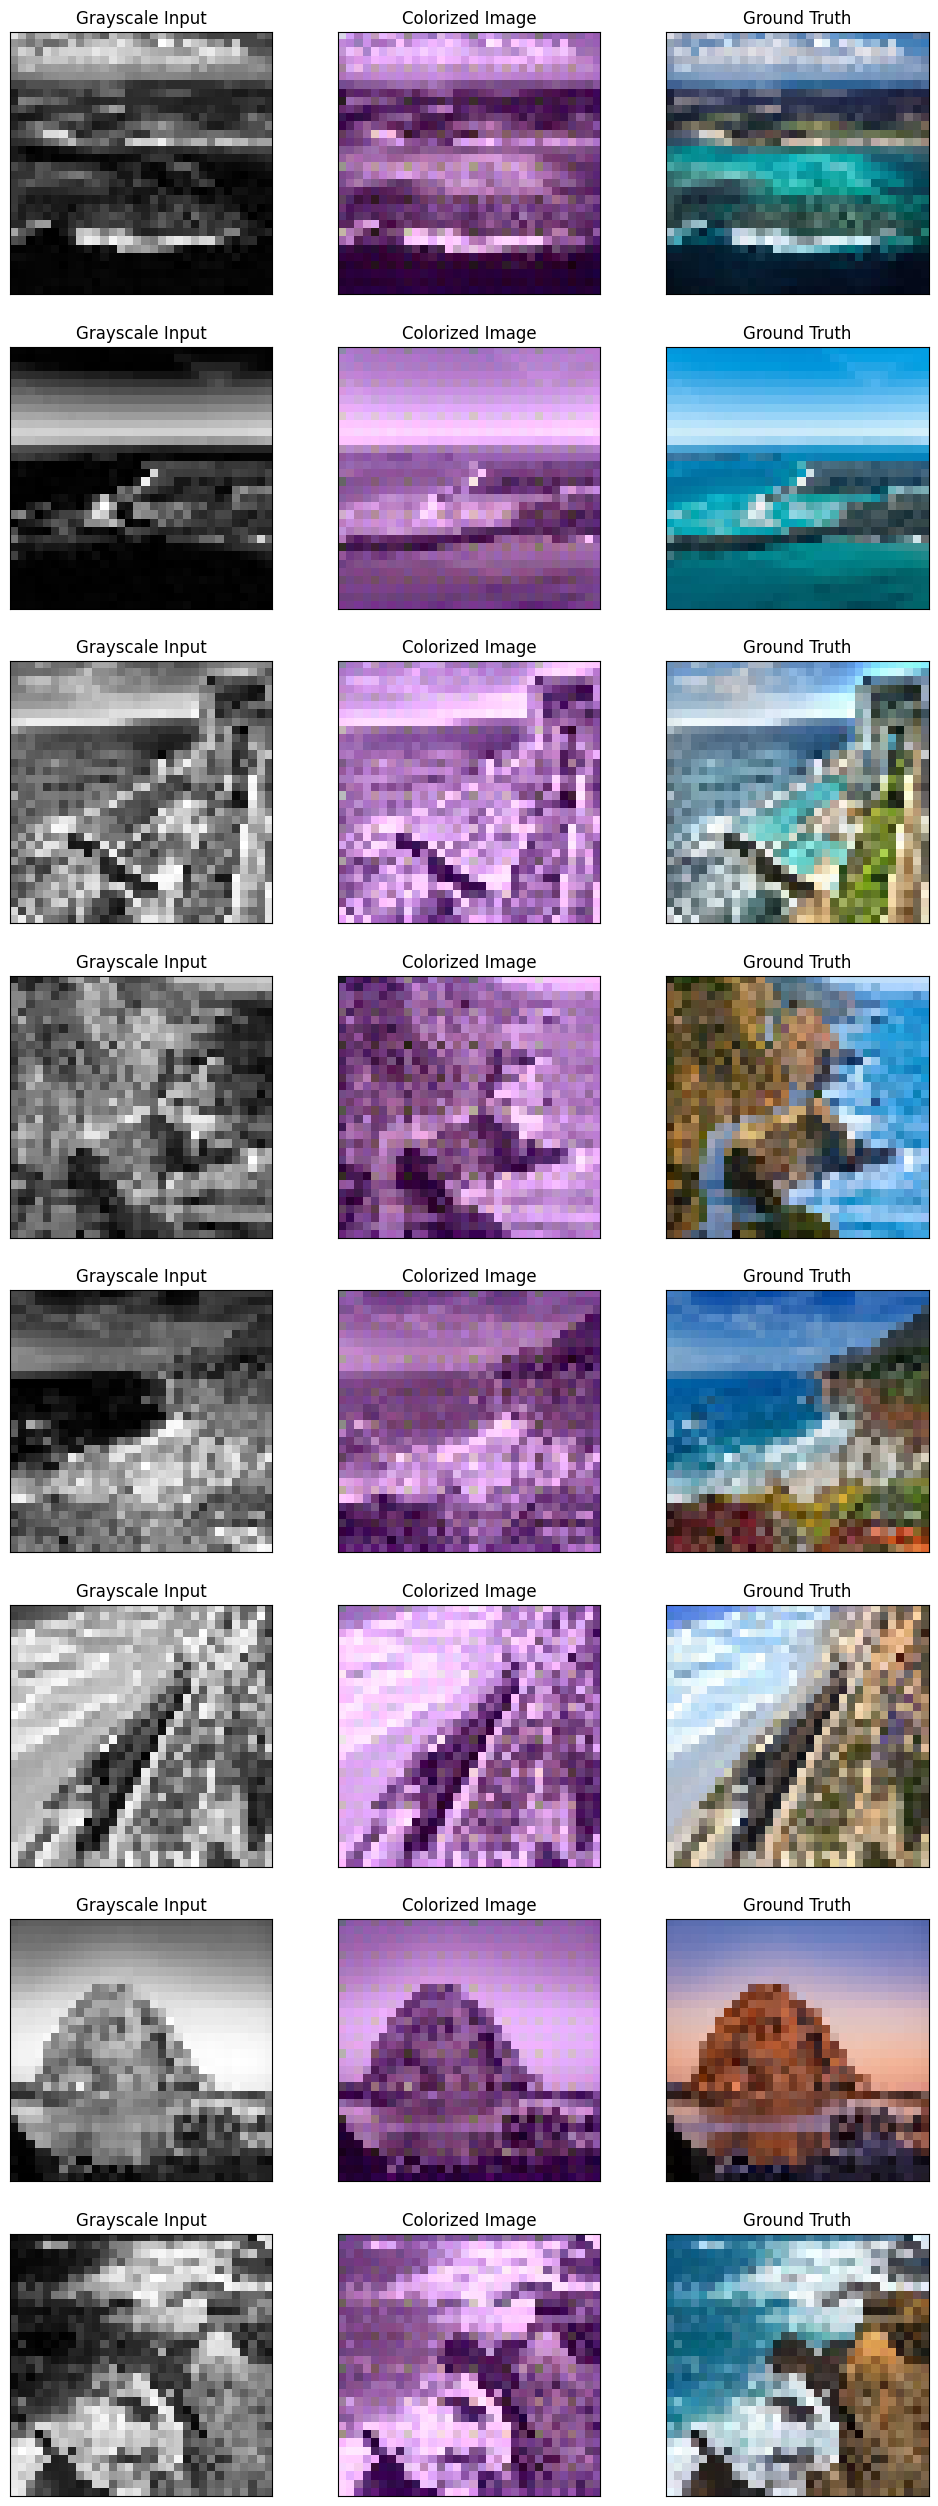

In [12]:
show_example_images(train_data_loader, number = 8, offset = 0);

# Test Image Results

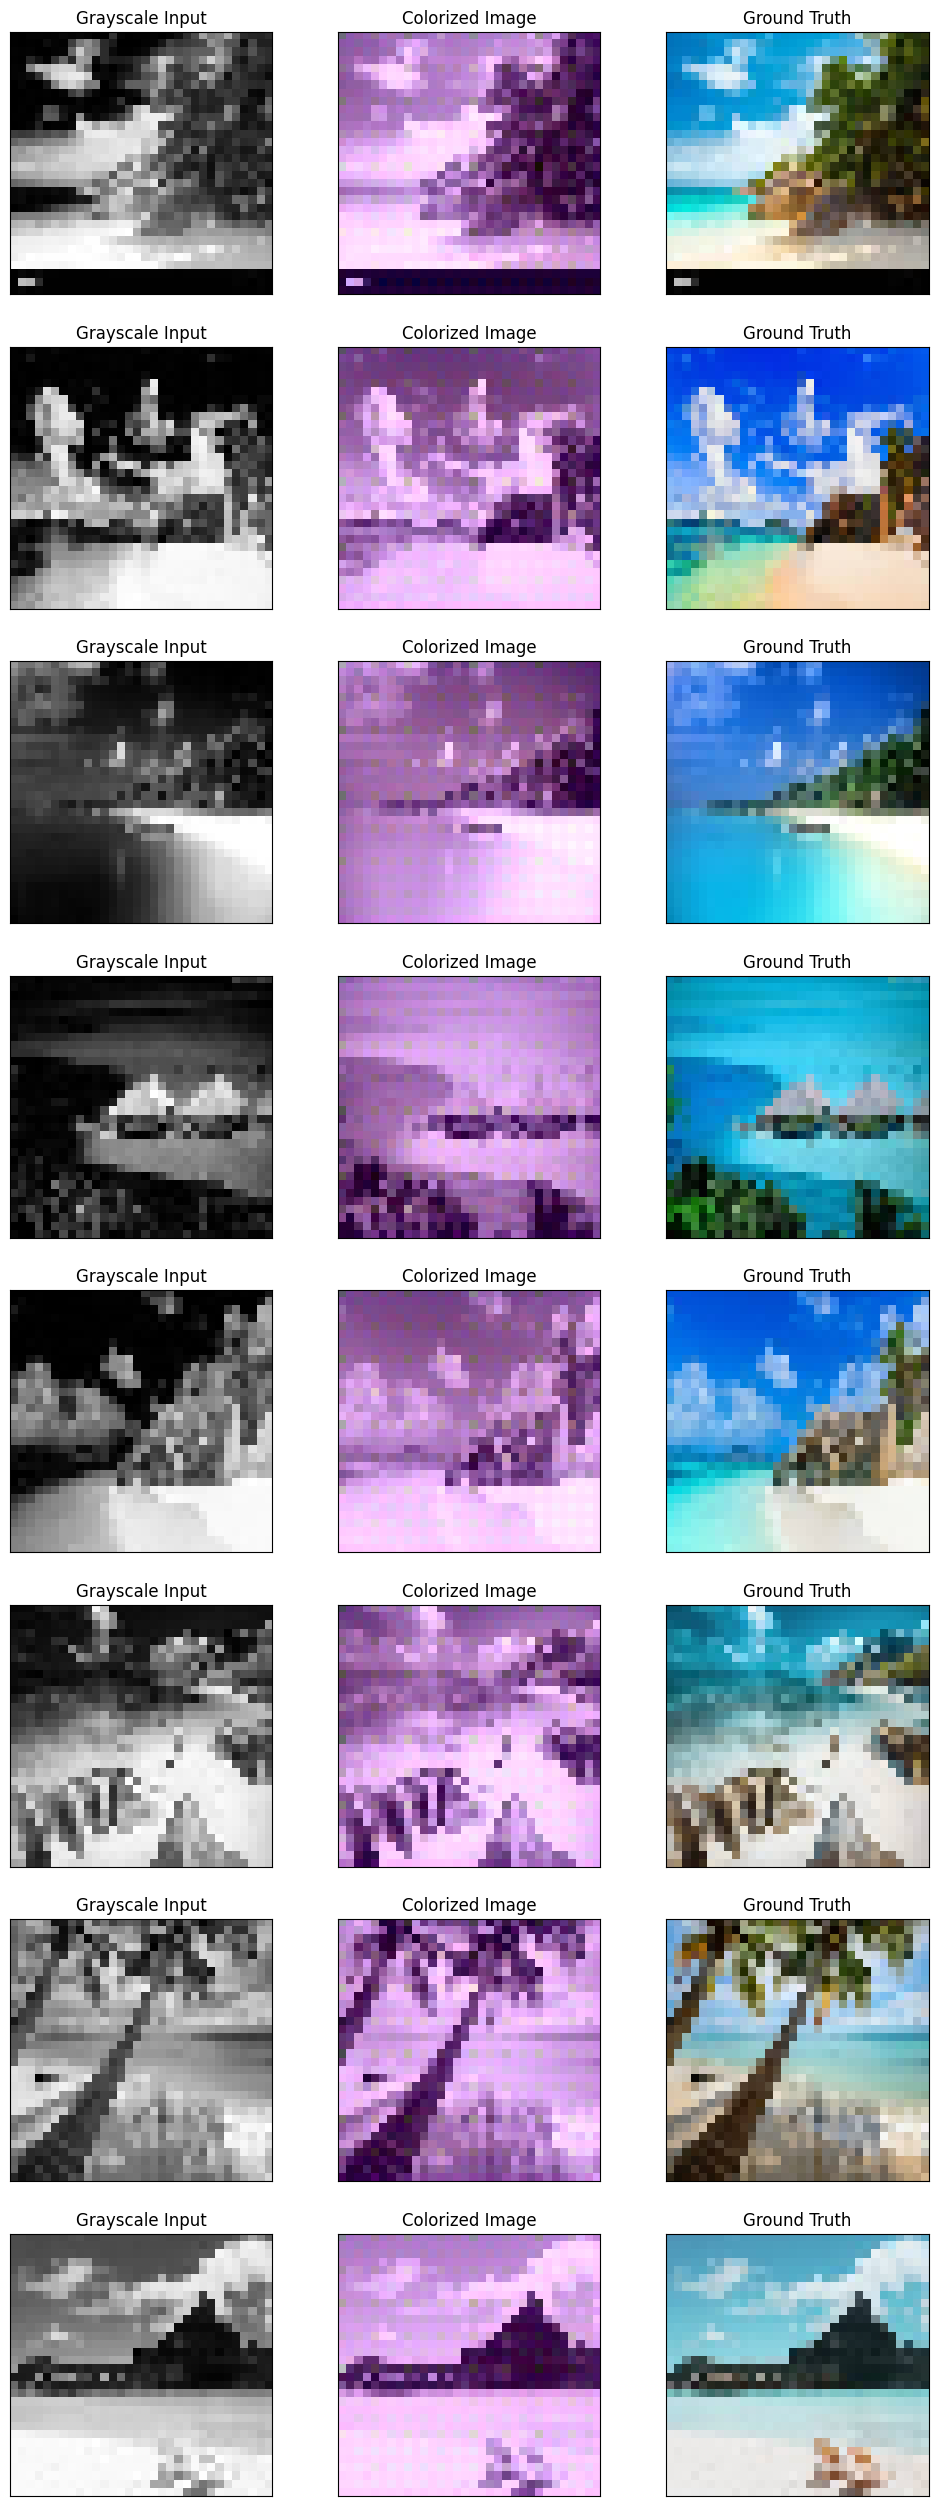

In [13]:
show_example_images(test_data_loader, number = 8, offset = 0);

# Visual Model Architecture

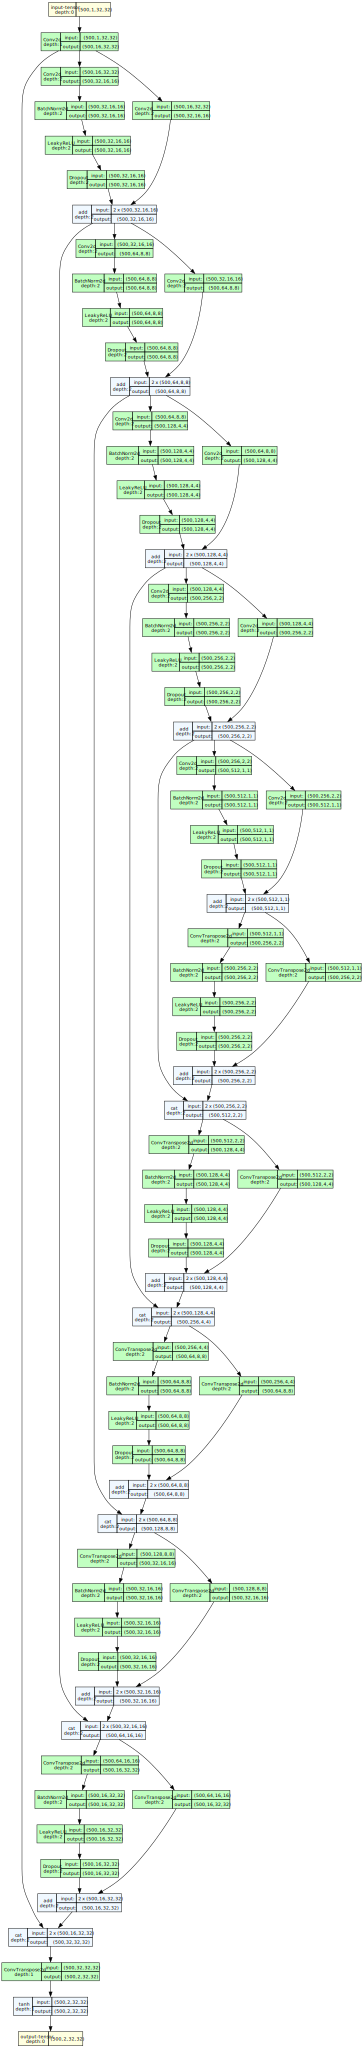

In [14]:
model_graph = draw_graph(generator, input_size=(h_batch_size, 1 ,h_image_size, h_image_size), device='cuda')
model_graph.visual_graph